<a href="https://colab.research.google.com/github/user074/EmotionTransformer/blob/main/Latent_Transformer.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# First, authenticate your Google Drive account
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !curl -L -o imagenet_cin.yaml -C - 'https://app.koofr.net/links/90cbd5aa-ef70-4f5e-99bc-f12e5a89380e?path=%2F2021-04-03T19-39-50_cin_transformer%2Fconfigs%2F2021-04-03T19-39-50-project.yaml' #ImageNet (cIN)
# !curl -L -o imagenet_cin.ckpt -C - 'https://app.koofr.net/content/links/90cbd5aa-ef70-4f5e-99bc-f12e5a89380e/files/get/last.ckpt?path=%2F2021-04-03T19-39-50_cin_transformer%2Fcheckpoints%2Flast.ckpt' #ImageNet (cIN)

In [2]:
!pip install -q git+https://github.com/huggingface/datasets
!pip install -q git+https://github.com/huggingface/transformers

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import sys
import torch

from datasets import *
# from transformers import ViTFeatureExtractor
# from transformers import ViTModel
# from transformers import TrainingArguments, Trainer
# from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np
import pandas as pd 
import torch.nn as nn
import pickle
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.metrics import confusion_matrix

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 54.8 MB/s eta 0:00:00


# Clone the Repo and load the model checkpoiont

In [3]:
!git clone https://github.com/CompVis/taming-transformers
%cd taming-transformers

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1339, done.
remote: Total 1339 (delta 0), reused 0 (delta 0), pack-reused 1339
Receiving objects: 100% (1339/1339), 409.77 MiB | 72.27 MiB/s, done.
Resolving deltas: 100% (281/281), done.
/content/taming-transformers


In [4]:
!mkdir logs

In [5]:
# !cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/2020-11-13T21-41-45_faceshq_transformer.zip' /content/taming-transformers/logs
# !unzip /content/taming-transformers/logs/2020-11-13T21-41-45_faceshq_transformer.zip -d /content/taming-transformers/logs/

In [6]:
!cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/2020-11-09T13-33-36_faceshq_vqgan.zip' /content/taming-transformers/logs
!unzip /content/taming-transformers/logs/2020-11-09T13-33-36_faceshq_vqgan.zip -d /content/taming-transformers/logs/

Archive:  /content/taming-transformers/logs/2020-11-09T13-33-36_faceshq_vqgan.zip
   creating: /content/taming-transformers/logs/2020-11-09T13-33-36_faceshq_vqgan/
   creating: /content/taming-transformers/logs/2020-11-09T13-33-36_faceshq_vqgan/checkpoints/
 extracting: /content/taming-transformers/logs/2020-11-09T13-33-36_faceshq_vqgan/checkpoints/last.ckpt  
   creating: /content/taming-transformers/logs/2020-11-09T13-33-36_faceshq_vqgan/configs/
 extracting: /content/taming-transformers/logs/2020-11-09T13-33-36_faceshq_vqgan/configs/2020-11-09T13-33-36-lightning.yaml  
 extracting: /content/taming-transformers/logs/2020-11-09T13-33-36_faceshq_vqgan/configs/2020-11-09T13-33-36-project.yaml  


In [7]:
# !mkdir -p logs/2020-11-09T13-31-51_sflckr/checkpoints
# !wget 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' -O 'logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt'
# !mkdir logs/2020-11-09T13-31-51_sflckr/configs
# !wget 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' -O 'logs/2020-11-09T13-31-51_sflckr/configs/2020-11-09T13-31-51-project.yaml'

In [8]:
%%capture
%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops>=0.3.0
sys.path.append(".")

# also disable grad to save memory
torch.set_grad_enabled(False)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
!mkdir output

In [10]:
# !python scripts/make_samples.py --outdir output -r logs/2020-11-13T21-41-45_faceshq_transformer/


In [11]:
# # download a VQGAN with f=16 (16x compression per spatial dimension) and with a codebook with 1024 entries
!mkdir -p logs/vqgan_imagenet_f16_1024/checkpoints
!mkdir -p logs/vqgan_imagenet_f16_1024/configs
!wget 'https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1' -O 'logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt' 
!wget 'https://heibox.uni-heidelberg.de/f/6ecf2af6c658432c8298/?dl=1' -O 'logs/vqgan_imagenet_f16_1024/configs/model.yaml' 

# # download a VQGAN with f=16 (16x compression per spatial dimension) and with a larger codebook (16384 entries)
# !mkdir -p logs/vqgan_imagenet_f16_16384/checkpoints
# !mkdir -p logs/vqgan_imagenet_f16_16384/configs
# !wget 'https://heibox.uni-heidelberg.de/f/867b05fc8c4841768640/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt' 
# !wget 'https://heibox.uni-heidelberg.de/f/274fb24ed38341bfa753/?dl=1' -O 'logs/vqgan_imagenet_f16_16384/configs/model.yaml' 

# download a VQGAN with f=8 (8x compression per spatial dimension) and a larger codebook-size with 8192 entries
# !mkdir -p logs/vqgan_gumbel_f8/checkpoints
# !mkdir -p logs/vqgan_gumbel_f8/configs
# !wget 'https://heibox.uni-heidelberg.de/f/34a747d5765840b5a99d/?dl=1' -O 'logs/vqgan_gumbel_f8/checkpoints/last.ckpt' 
# !wget 'https://heibox.uni-heidelberg.de/f/b24d14998a8d4f19a34f/?dl=1' -O 'logs/vqgan_gumbel_f8/configs/model.yaml' 

--2023-04-08 14:31:38--  https://heibox.uni-heidelberg.de/f/140747ba53464f49b476/?dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/8592465a-b537-4fc7-91ac-3af64c754794/last.ckpt [following]
--2023-04-08 14:31:39--  https://heibox.uni-heidelberg.de/seafhttp/files/8592465a-b537-4fc7-91ac-3af64c754794/last.ckpt
Reusing existing connection to heibox.uni-heidelberg.de:443.
HTTP request sent, awaiting response... 200 OK
Length: 957954257 (914M) [application/octet-stream]
Saving to: ‘logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt’

logs/vqgan_imagenet 100%[===================>] 913.58M  8.26MB/s    in 78s     

2023-04-08 14:32:57 (11.7 MB/s) - ‘logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt’ saved [957954257/957954257]

--2023-04-08 14:32:57--  h

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/utils.py' '/content/taming-transformers/taming/data'

# Utility Functions from VQGAN

In [13]:
import yaml
import torch
from omegaconf import OmegaConf
from taming.models.vqgan import VQModel, GumbelVQ

def load_config(config_path, display=False):
  config = OmegaConf.load(config_path)
  if display:
    print(yaml.dump(OmegaConf.to_container(config)))
  return config

def load_vqgan(config, ckpt_path=None, is_gumbel=False):
  if is_gumbel:
    model = GumbelVQ(**config.model.params)
  else:
    model = VQModel(**config.model.params)
  if ckpt_path is not None:
    sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
    missing, unexpected = model.load_state_dict(sd, strict=False)
  return model.eval()

def preprocess_vqgan(x):
  x = 2.*x - 1.
  return x

def custom_to_pil(x):
  x = x.detach().cpu()
  x = torch.clamp(x, -1., 1.)
  x = (x + 1.)/2.
  x = x.permute(1,2,0).numpy()
  x = (255*x).astype(np.uint8)
  x = Image.fromarray(x)
  if not x.mode == "RGB":
    x = x.convert("RGB")
  return x

def reconstruct_with_vqgan(x, model):
  # could also use model(x) for reconstruction but use explicit encoding and decoding here
  z, _, [_, _, indices] = model.encode(x)
  print(f"VQGAN --- {model.__class__.__name__}: latent shape: {z.shape[2:]}")
  xrec = model.decode(z)
  return xrec

# Load VQGAN 1024 model

In [ ]:
config1024 = load_config("logs/vqgan_imagenet_f16_1024/configs/model.yaml", display=False)
# config16384 = load_config("logs/vqgan_imagenet_f16_16384/configs/model.yaml", display=False)

model1024 = load_vqgan(config1024, ckpt_path="logs/vqgan_imagenet_f16_1024/checkpoints/last.ckpt").to(DEVICE)
# model16384 = load_vqgan(config16384, ckpt_path="logs/vqgan_imagenet_f16_16384/checkpoints/last.ckpt").to(DEVICE)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

8.19kB [00:00, 474kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


Reduce Image size with this

In [ ]:
# config32x32 = load_config("logs/vqgan_gumbel_f8/configs/model.yaml", display=False)
# model32x32 = load_vqgan(config32x32, ckpt_path="logs/vqgan_gumbel_f8/checkpoints/last.ckpt", is_gumbel=True).to(DEVICE)

# Load FaceHQ model and show image from the code book

In [14]:
configFace = load_config("logs/2020-11-09T13-33-36_faceshq_vqgan/configs/2020-11-09T13-33-36-project.yaml", display=True)
modelFace = load_vqgan(configFace, ckpt_path="logs/2020-11-09T13-33-36_faceshq_vqgan/checkpoints/last.ckpt").to(DEVICE)

data:
  params:
    batch_size: 3
    num_workers: 8
    train:
      params:
        crop_size: 256
        size: 256
      target: taming.data.faceshq.FacesHQTrain
    validation:
      params:
        crop_size: 256
        size: 256
      target: taming.data.faceshq.FacesHQValidation
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    ddconfig:
      attn_resolutions:
      - 16
      ch: 128
      ch_mult:
      - 1
      - 1
      - 2
      - 2
      - 4
      double_z: false
      dropout: 0.0
      in_channels: 3
      num_res_blocks: 2
      out_ch: 3
      resolution: 256
      z_channels: 256
    embed_dim: 256
    lossconfig:
      params:
        codebook_weight: 1.0
        disc_conditional: false
        disc_in_channels: 3
        disc_start: 30001
        disc_weight: 0.8
      target: taming.modules.losses.vqperceptual.VQLPIPSWithDiscriminator
    n_embed: 1024
  target: taming.models.vqgan.VQModel

Working with z of shape (1, 256, 1

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 126MB/s]


8.19kB [00:00, 465kB/s]                    


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [15]:
# vqgan_model = VQModel()
# vqgan_model.load_state_dict(torch.load("logs/vqgan_gumbel_f8/checkpoints/last.ckpt"))
# vqgan_model.to(DEVICE)

## Showing the decoded face

The decoded face with the faceHQ model

In [16]:
!cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/00019.jpg' /content

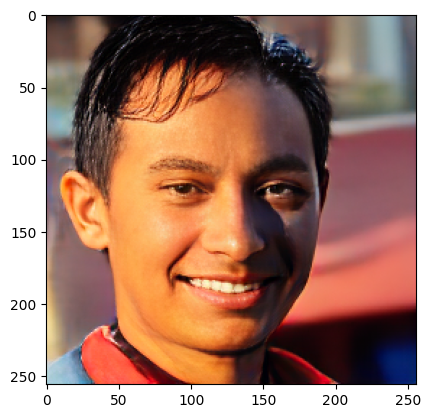

In [17]:
from PIL import Image

im = Image.open('/content/00019.jpg').convert('RGB').resize((256, 256))
im_tensor = torch.tensor(np.array(im)).permute(2, 0, 1) / 255
z, a, b = modelFace.encode(im_tensor.to(DEVICE).unsqueeze(0) * 2 - 1) 
idx = b[-1] # The codebook entries (16x16 tokens so shape is [256])
z_q = modelFace.quantize.embedding(idx).reshape(1, 16, 16, 256).permute(0,3,1,2) #quantize:quant, emb_loss, info 
plt.imshow(modelFace.decode(z_q).add(1).div(2).cpu().squeeze().permute(1, 2, 0))

The decoded face witht he imageNet 1024 codebook

In [18]:
# im = Image.open('/content/00019.jpg').convert('RGB').resize((256, 256))
# im_tensor = torch.tensor(np.array(im)).permute(2, 0, 1) / 255
# z, a, b = model1024.encode(im_tensor.to(DEVICE).unsqueeze(0) * 2 - 1) 
# idx = b[-1] # The codebook entries (16x16 tokens so shape is [256])
# z_q = model1024.quantize.embedding(idx).reshape(1, 16, 16, 256).permute(0,3,1,2) #quantize:quant, emb_loss, info 
# plt.imshow(model1024.decode(z_q).add(1).div(2).cpu().squeeze().permute(1, 2, 0))

NameError: ignored

# Copy and clean the FER data then turn them into Quantized indexes

Some code are referenced from here: https://github.com/lwachowiak/Emotion-Recognition-with-ViT/blob/main/Emotion_Recognition_using_the_Vision_Transformer.ipynb

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/fertest.jpg' /content
!cp '/content/drive/MyDrive/CUNY-Phd/data/fer2013/fer2013.csv' /content/

In [ ]:
string_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral']

In [ ]:
fer_df = pd.read_csv("/content/fer2013.csv")  # available on kaggle
fer_df.head()

### Get the FER data prepration into the pandas dataframe

In [ ]:
def prepare_fer_data(data):
    """ Prepare fer data for vision transformer 
        input: fer df loaded from csv
        output: df that can be load into a huggingface dataset """

    # outputs
    image_list = []
    image_labels = list(map(int, data['emotion']))
    
    # go over all images
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        # adapt grayscale to rgb format (change single values to triplets of the same value)
        image = image[..., np.newaxis]
        image = np.repeat(image, 3, axis=2)
        # convert to list format used by the later functions
        image = image.astype(int).tolist()
        # save to output
        image_list.append(image)

    output_df = pd.DataFrame(list(zip(image_list, image_labels)),
               columns =['img', 'label'])
        
    return output_df

In [ ]:
fer_train_df = prepare_fer_data(fer_df[fer_df['Usage']=='Training'])
fer_test_df = prepare_fer_data(fer_df[fer_df['Usage']=='PrivateTest'])
fer_val_df = prepare_fer_data(fer_df[fer_df['Usage']=='PublicTest'])

In [ ]:
fer_train_df.head()

In [ ]:
print(len(fer_train_df))
print(len(fer_test_df))
print(len(fer_val_df))

In [ ]:
train_ds = Dataset.from_pandas(fer_train_df)
#undersample train due to memory issues on google colab
# splits = train_ds.train_test_split(test_size=0.15)
# train_ds = splits["train"]

val_ds = Dataset.from_pandas(fer_val_df)
test_ds = Dataset.from_pandas(fer_test_df)

train_ds

In [ ]:
# image size 
np.array(train_ds[0]["img"]).shape

### Preprocess with 1024 model to save to pickle file
- Convert the quantized value of the model1024
- Provide index of the quantized value in the codebook

In [ ]:
from PIL import Image

# Function to convert a value to a Python list, handling integers and empty tensors
def mixed_to_list(value):
    if isinstance(value, torch.Tensor):
        if value.nelement() == 0:  # Check if the tensor is empty
            return []
        else:
            return value.numpy().tolist()
    elif isinstance(value, int):
        return [value]
    else:
        raise ValueError(f"Unsupported data type: {type(value)}")

def preprocess_images(examples):
    """ Prepare datasets for vision transformer 
    input: dataset with images in their orignal size 
    output: dataset with pixelvalues computed by the feature extractor added """
    # get batch of images
    images = examples['img']
    # convert to list of NumPy arrays of shape (C, H, W)
    # print('convert')
    # images = [np.array(image, dtype=np.uint8) for image in images]
    # # images = [np.moveaxis(image, source=-1, destination=0) for image in images]
    # # preprocess and add pixel_values
    # ims = [Image.fromarray(image).convert('RGB').resize((256, 256)) for image in images]
    # print(ims[0].shape)
    # im_tensors = [torch.tensor(np.array(im)).permute(2, 0, 1) / 255 for im in ims]
    # print('tensor finish')
    result = list(map(model_quantizer, images))
    # inputs = feature_extractor(images=images)
    df = pd.DataFrame(result, columns=['quantize_values', 'index'])
    examples['quantize_values'] = df['quantize_values'].apply(mixed_to_list)
    examples['index'] = df['index'].apply(mixed_to_list)

    return examples


def model_quantizer(image):
    im = Image.fromarray(np.array(image, dtype=np.uint8)).convert('RGB').resize((256, 256))
    im_tensor = torch.tensor(np.array(im)).permute(2, 0, 1) / 255
    z, a, b = model1024.encode(im_tensor.to(DEVICE).unsqueeze(0) * 2 - 1) 
    idx = b[-1] # The codebook entries (16x16 tokens so shape is [256])
    z_q = model1024.quantize.embedding(idx).reshape(1, 16, 16, 256).permute(0,3,1,2) #quantize:quant, emb_loss, info 
    return (z_q.cpu(), idx.cpu())


In [ ]:
# #It is outdated since the returned value is on CPU not GPU
# def decode_image(image):
#     return model1024.decode(image).add(1).div(2).cpu().squeeze().permute(1, 2, 0)

#Take the data on GPU before decode it
def decode_list_image(image):
    torch_image = torch.tensor(image).to(DEVICE)
    return model1024.decode(torch_image).add(1).div(2).cpu().squeeze().permute(1, 2, 0)


In [ ]:
example1 = preprocess_images(train_ds[0:2])

In [ ]:
plt.figure(figsize=(20, 10))
#show one original image
plt.subplot(1, 2, 1)
plt.imshow(np.array(train_ds[0]["img"]))
plt.title('Original Image')
plt.subplot(1, 2, 2)
#show one decoded quantized image
plt.imshow(decode_list_image(example1['quantize_values'][0]))
plt.title('Quantized Image')
plt.show()



In [ ]:
#example1['quantize_values'][0].shape
#torch.Size([1, 256, 16, 16])

#model1024.decode(example1['quantize_values'][0]).shape
#torch.Size([1, 3, 256, 256])

train_ds columns: 'img', 'label', 'quantize_values', 'index'
quantize_values are the quantized value results. 
index are the indexes in the codebook

Save the data to the google drive as pickle file. The data are off from the GPU and torch and are saved in lists and arrays. If we need to re-import the data we need to be aware and use 

In [ ]:
# features of the new dataset with an additional column for the preprocess 224x224x3 images 
features = Features({
    'label': ClassLabel(names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']),
    'img': Array3D(dtype="int64", shape=(48,48,3)),
    'quantize_values': Array4D(dtype="float32", shape=(1, 256, 16, 16)),
    'index': Sequence(feature=Value("int64"))
    # 'index': Array2D(dtype="int64", shape=(256, 1))
})

In [ ]:
preprocessed_test_ds = test_ds.map(preprocess_images, batched=True, features=features)
with open('preprocessed_test_ds_1024.pickle', 'wb') as handle:
   pickle.dump(preprocessed_test_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp 'preprocessed_test_ds_1024.pickle' '/content/drive/MyDrive/Colab Notebooks/LatentTransformer'

In [ ]:
preprocessed_val_ds = val_ds.map(preprocess_images, batched=True, features=features)
with open('preprocessed_val_ds_1024.pickle', 'wb') as handle:
   pickle.dump(preprocessed_val_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp 'preprocessed_val_ds_1024.pickle' '/content/drive/MyDrive/Colab Notebooks/LatentTransformer'

In [ ]:
# batch_size=1 probably to avoid local pointer. So we can save the entire data to disk: Not working
# Might be memory issue
preprocessed_train_ds = train_ds.map(preprocess_images, batched=True, batch_size=1, features=features)
with open('preprocessed_train_ds_1024.pickle', 'wb') as handle:
    pickle.dump(preprocessed_train_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
!cp 'preprocessed_train_ds_1024.pickle' '/content/drive/MyDrive/Colab Notebooks/LatentTransformer'

In [ ]:
preprocessed_train_ds

In [ ]:
# show 100 images from the dataset
fig, axes = plt.subplots(10,10, figsize=(11,11))
for i,ax in enumerate(axes.flat):
  data_for_image = np.array(preprocessed_train_ds[i]["pixel_values"])
  data_for_image[data_for_image < 0] = 0 
  ax.imshow(np.transpose(data_for_image, (0, 1,2)), interpolation='nearest')
  ax.set_axis_off()


In [ ]:
# show 100 decoded images from the dataset
fig, axes = plt.subplots(10,10, figsize=(11,11))
for i,ax in enumerate(axes.flat):
  data_for_image = np.array(decode_list_image(preprocessed_train_ds[i]["quantize_values"]))
  data_for_image[data_for_image < 0] = 0 
  ax.imshow(np.transpose(data_for_image, (0,1,2)), interpolation='nearest')
  ax.set_axis_off()


### Process the index of quantized values for the facesHQ model

In [ ]:
from PIL import Image


#index only
def preprocess_images(examples):
    """ Prepare datasets for vision transformer 
    input: dataset with images in their orignal size 
    output: dataset with pixelvalues computed by the feature extractor added """
    # get batch of images
    images = examples['img']
    result = list(map(model_quantizer, images))
    df = pd.DataFrame(result, columns=['quantize_values', 'index'])
    examples['quantize_values'] = df['quantize_values'].apply(mixed_to_list)
    examples['index'] = df['index'].apply(mixed_to_list)

    return examples

#change the model used. Although I probably can optimize it a bit
def model_quantizer(image):
    im = Image.fromarray(np.array(image, dtype=np.uint8)).convert('RGB').resize((256, 256))
    im_tensor = torch.tensor(np.array(im)).permute(2, 0, 1) / 255
    z, a, b = modelFace.encode(im_tensor.to(DEVICE).unsqueeze(0) * 2 - 1) 
    idx = b[-1] # The codebook entries (16x16 tokens so shape is [256])
    z_q = modelFace.quantize.embedding(idx).reshape(1, 16, 16, 256).permute(0,3,1,2) #quantize:quant, emb_loss, info 
    return (z_q.cpu(), idx.cpu())

In [ ]:
#Take the data on GPU before decode it
def decode_list_image(image):
    torch_image = torch.tensor(image).to(DEVICE)
    return modelFace.decode(torch_image).add(1).div(2).cpu().squeeze().permute(1, 2, 0)

In [ ]:
#sanity check
example1 = preprocess_images(train_ds[0:10])

i = 9

plt.figure(figsize=(20, 10))
#show one original image
plt.subplot(1, 2, 1)
plt.imshow(np.array(train_ds[i]["img"]))
plt.title('Original Image')
plt.subplot(1, 2, 2)
#show one decoded quantized image
plt.imshow(decode_list_image(example1['quantize_values'][i]))
plt.title('Quantized Image')
plt.show()

In [ ]:
# features of the new dataset with an additional column for the preprocess 224x224x3 images 
features = Features({
    'label': ClassLabel(names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']),
    'img': Array3D(dtype="int64", shape=(48,48,3)),
    # 'quantize_values': Array4D(dtype="float32", shape=(1, 256, 16, 16)),
    'index': Sequence(feature=Value("int64"))
    # 'index': Array2D(dtype="int64", shape=(256, 1))
})

In [ ]:
preprocessed_test_ds = test_ds.map(preprocess_images, batched=True, features=features)
with open('preprocessed_test_ds_facehq_index.pickle', 'wb') as handle:
   pickle.dump(preprocessed_test_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

!cp 'preprocessed_test_ds_facehq_index.pickle' '/content/drive/MyDrive/Colab Notebooks/LatentTransformer'

preprocessed_val_ds = val_ds.map(preprocess_images, batched=True, features=features)
with open('preprocessed_val_ds_facehq_index.pickle', 'wb') as handle:
   pickle.dump(preprocessed_val_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

!cp 'preprocessed_val_ds_facehq_index.pickle' '/content/drive/MyDrive/Colab Notebooks/LatentTransformer'

# batch_size=1 probably to avoid local pointer. So we can save the entire data to disk: Not working
# Might be memory issue
preprocessed_train_ds = train_ds.map(preprocess_images, batched=True, batch_size=1, features=features)
with open('preprocessed_train_ds_facehq_index.pickle', 'wb') as handle:
    pickle.dump(preprocessed_train_ds, handle, protocol=pickle.HIGHEST_PROTOCOL)

!cp 'preprocessed_train_ds_facehq_index.pickle' '/content/drive/MyDrive/Colab Notebooks/LatentTransformer'

# Copy Saved Pre-preocessed data to local file

## Copy the 1024 model data to local file and load them

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/preprocessed_val_ds_1024.pickle'
!cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/preprocessed_test_ds_1024.pickle'
!cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/preprocessed_train_ds_1024.pickle'

In [ ]:
with open('preprocessed_val_ds_1024.pickle', 'rb') as handle:
    preprocessed_val = pickle.load(handle)

with open('/content/preprocessed_test_ds_1024_index.pickle', 'rb') as handle:
    preprocessed_test = pickle.load(handle)

with open('/content/preprocessed_train_ds_1024_index.pickle', 'rb') as handle:
    preprocessed_train = pickle.load(handle)

# Build a FaceHQ Transformer model based on the codebook entries

## Copy the faceHQ model data to local file and load them

In [27]:
!cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/preprocessed_val_ds_facehq_index.pickle' /content
!cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/preprocessed_test_ds_facehq_index.pickle' /content
!cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/preprocessed_train_ds_facehq_index.pickle' /content


In [28]:

with open('/content/preprocessed_val_ds_facehq_index.pickle', 'rb') as handle:
    preprocessed_val = pickle.load(handle)

with open('/content/preprocessed_test_ds_facehq_index.pickle', 'rb') as handle:
    preprocessed_test = pickle.load(handle)

with open('/content/preprocessed_train_ds_facehq_index.pickle', 'rb') as handle:
    preprocessed_train = pickle.load(handle)


Probably need to cat the img to the idx since the coord in https://github.com/CompVis/taming-transformers/blob/3ba01b241669f5ade541ce990f7650a3b8f65318/taming/data/faceshq.py#L75

    coord = np.arange(h*w).reshape(h,w,1)/(h*w)

does this thing for the input of the transformer. The c index is the image

the condition stage key used for c index is coord

    c = model.get_input(cond_key, example).to(model.device)

then it use 

    quant_c, c_indices = model.encode_to_c(c)

The model just use

    patch = torch.cat((cpatch, patch), dim=1)
as the input

So I will probbaly need to just encode he image to c then cat it to the index to resolve the conditional length issue

In [29]:
preprocessed_val=preprocessed_val.remove_columns('img')
preprocessed_test=preprocessed_test.remove_columns('img')
preprocessed_train=preprocessed_train.remove_columns('img')

In [30]:
preprocessed_train

Dataset({
    features: ['label', 'index'],
    num_rows: 28709
})

## Import a pre-trained faceHQ transformer model unconditional

Import the Model

Get the transformer layers

Add the classification header for the transformer output

In [19]:
!cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/2020-11-13T21-41-45_faceshq_transformer.zip' /content/taming-transformers/logs
!unzip /content/taming-transformers/logs/2020-11-13T21-41-45_faceshq_transformer.zip -d /content/taming-transformers/logs/

Archive:  /content/taming-transformers/logs/2020-11-13T21-41-45_faceshq_transformer.zip
   creating: /content/taming-transformers/logs/2020-11-13T21-41-45_faceshq_transformer/
   creating: /content/taming-transformers/logs/2020-11-13T21-41-45_faceshq_transformer/checkpoints/
 extracting: /content/taming-transformers/logs/2020-11-13T21-41-45_faceshq_transformer/checkpoints/last.ckpt  
   creating: /content/taming-transformers/logs/2020-11-13T21-41-45_faceshq_transformer/configs/
 extracting: /content/taming-transformers/logs/2020-11-13T21-41-45_faceshq_transformer/configs/2020-11-13T21-41-45-lightning.yaml  
 extracting: /content/taming-transformers/logs/2020-11-13T21-41-45_faceshq_transformer/configs/2020-11-13T21-41-45-project.yaml  


In [20]:
import torch.nn as nn
import torch
from torch.autograd import Variable

%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops transformers

config_path = "logs/2020-11-13T21-41-45_faceshq_transformer/configs/2020-11-13T21-41-45-project.yaml"
config = OmegaConf.load(config_path)
print(yaml.dump(OmegaConf.to_container(config)))


data:
  params:
    batch_size: 2
    num_workers: 8
    train:
      params:
        coord: true
        crop_size: 256
        size: 256
      target: taming.data.faceshq.FacesHQTrain
    validation:
      params:
        coord: true
        crop_size: 256
        size: 256
      target: taming.data.faceshq.FacesHQValidation
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config:
      params:
        down_factor: 16
        n_embed: 1024
      target: taming.modules.misc.coord.CoordStage
    cond_stage_key: coord
    first_stage_config:
      params:
        ckpt_path: logs/2020-11-09T13-33-36_faceshq_vqgan/checkpoints/last.ckpt
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 3
          num_res_blocks: 2
          out_ch: 3
          resolution

Initiate the model

In [21]:
from taming.models.cond_transformer import Net2NetTransformer
modelFaceTransformer = Net2NetTransformer(**config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Restored from logs/2020-11-09T13-33-36_faceshq_vqgan/checkpoints/last.ckpt


In [22]:
#Load checkpoints
ckpt_path = "logs/2020-11-13T21-41-45_faceshq_transformer/checkpoints/last.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = modelFaceTransformer.load_state_dict(sd, strict=False)

In [23]:
modelFaceTransformer.cuda().eval()
torch.set_grad_enabled(False)
model_transformer = modelFaceTransformer.transformer


In [54]:
class modelTransformer(nn.Module):
    def __init__(self, model_transformer):
        super(modelTransformer, self).__init__()
        self.transformer = model_transformer
        self.classifier1 = nn.Linear(1024, 256)
        self.classifier2 = nn.Linear(256, 256)
        self.classifier3 = nn.Linear(256, 7)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)



    def forward(self, index, labels):
        print(index)
        logits, _  = self.transformer(idx =index)
        logits = logits[:, -1, :] 
        logits = self.classifier1(logits)
        logits = self.relu(logits)
        logits = self.classifier2(logits)
        logits = self.relu(logits)
        logits = self.classifier3(logits)
        logits = self.softmax(logits)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 7), labels.view(-1))
            loss = Variable(loss, requires_grad = True)
        
        return loss, logits

The issue here probably is the loss function. Clearly I am defining a new loss function based on the out put. But the transformer loss function is:

            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))


https://github.com/CompVis/taming-transformers/blob/3ba01b241669f5ade541ce990f7650a3b8f65318/taming/modules/transformer/mingpt.py#L178


From the issue here:
https://github.com/CompVis/taming-transformers/issues/101

Technically they are similar, unless my training loss is bad somehow. Need to check



1.   Need to chnage the input - condition cat index. Pass one single input to verify
2.   Need to verify the loss is working as intended



In [61]:
face_model = modelTransformer(model_transformer)
face_model.cuda().eval()
num_layers = len(list(face_model.modules()))
nameList = [name for name, module in face_model.named_modules()]
# for i, param in enumerate(face_model.parameters()):
#     if i >=  num_layers - 5:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

for i, param in enumerate(face_model.parameters()):
  param.requires_grad = True
face_model.to(DEVICE)

modelTransformer(
  (transformer): GPT(
    (tok_emb): Embedding(1024, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (key): Linear(in_features=1024, out_features=1024, bias=True)
          (query): Linear(in_features=1024, out_features=1024, bias=True)
          (value): Linear(in_features=1024, out_features=1024, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (resid_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (mlp): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
          (3): Dropout(p=0.0, inplace=False

In [62]:
face_model.to(DEVICE)

modelTransformer(
  (transformer): GPT(
    (tok_emb): Embedding(1024, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (key): Linear(in_features=1024, out_features=1024, bias=True)
          (query): Linear(in_features=1024, out_features=1024, bias=True)
          (value): Linear(in_features=1024, out_features=1024, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (resid_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (mlp): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
          (3): Dropout(p=0.0, inplace=False

### Old model

In [ ]:
new_head = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1024*256, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 7),
    nn.Softmax(dim=1)
)
model_transformer.head = new_head

model_transformer.to(DEVICE)


GPT(
  (tok_emb): Embedding(1024, 1024)
  (drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (key): Linear(in_features=1024, out_features=1024, bias=True)
        (query): Linear(in_features=1024, out_features=1024, bias=True)
        (value): Linear(in_features=1024, out_features=1024, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (resid_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=1024, out_features=4096, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=4096, out_features=1024, bias=True)
        (3): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (ln1): LayerNorm((1024,), eps=1e-05

In [ ]:
# Check if the model is trainable
trainable_params = any(param.requires_grad for param in model_transformer.parameters())

if trainable_params:
    print('The model is trainable')
else:
    print('The model is not trainable')

The model is trainable


In [ ]:
# model_transformer.head = None
# model_transformer.ln_f = None

class modelTransformer(nn.Module):
    def __init__(self, model_transformer):
        super(modelTransformer, self).__init__()
        self.transformer = model_transformer
        # self.hidden_units = model_transformer.config.vocab_size
        # self.new_head = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(self.hidden_units*256, 128),
        #     nn.ReLU(),
        #     nn.Dropout(0.1),
        #     nn.Linear(128, 7),
        #     nn.LogSoftmax(dim=1),
        # )

    def forward(self, index, labels):
        logits,_  = self.transformer(index)
        # outputs = self.transformer.ln_f(outputs)
        # logits = self.new_head(outputs)  # Pass through the new head

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 7), labels.view(-1))
            loss = Variable(loss, requires_grad = True)
        
        return loss, logits

# class modelTransformer(Net2NetTransformer):
#     def __init__(self, model_transformer, num_classes):
#         super(modelTransformer, self).__init__()
#         self.transformer = model_transformer
#         self.hidden_units = model_transformer.config.vocab_size
#         self.new_head = nn.Sequential(
#             nn.Linear(self.hidden_units, 128),
#             nn.ReLU(),
#             nn.Dropout(0.1),
#             nn.Linear(128, num_classes),
#             nn.LogSoftmax(dim=1),
#         )

#     def forward(self, index, labels):
#         outputs = self.transformer(index)
#         logits = self.new_head(outputs)  # Pass through the new head

#         loss = None
#         if labels is not None:
#             loss_fct = nn.CrossEntropyLoss()
#             loss = loss_fct(logits.view(-1, self.num_classes), labels.view(-1))
        
#         return loss, logits
        
#         # return logits

In [ ]:
# num_classes = 7
face_model = modelTransformer(model_transformer)
face_model.to(DEVICE)

modelTransformer(
  (transformer): GPT(
    (tok_emb): Embedding(1024, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (key): Linear(in_features=1024, out_features=1024, bias=True)
          (query): Linear(in_features=1024, out_features=1024, bias=True)
          (value): Linear(in_features=1024, out_features=1024, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (resid_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (mlp): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
          (3): Dropout(p=0.0, inplace=False

In [ ]:
# Check if the model is trainable
trainable_params = any(param.requires_grad for param in face_model.parameters())

if trainable_params:
    print('The model is trainable')
else:
    print('The model is not trainable')

The model is trainable


All right, so the model is initiated, and added a classification header. Although it seems that I can just use the transformer model since it has two stages, and the first stage is the vqgan model, the second stage is the transformer unconditional model. But anyway, I will just train the already processed first stage data. The processed vqgan data is saved to the google drive. I can just copy it and load it back with the index values since I only need that. Then I can do a trainer

So it seems that the model is not able to train with few reasons:
1. I try to just use the output of the transformer model, but it gives 'ValueError: Expected input batch_size (8192) to match target batch_size (32).' It seems that the trainer get train arguments is not right. Might need to modify the __getItem__ one. But I presume it will have more issues because of the forward method?

2. I try to inherit the Net2NetTransformer directly, but then I probably need to specify the arguments and dig deeper on how it works and how to modify it. I will try to do it later.

Some comments: when I check the model, and I try to hijack the layer but it doesnt work well. The possible examples might be super the transformer then modify the forward. Need to check. Also how does pytorch input, label, and output work? It's so different from tensorflow

In [ ]:
#Do a test pass of the model to ensure it works (pre batch)
# test_index = torch.randint(0, 1000, (1, 512)).cuda().to(DEVICE)
# test_labels = torch.randint(0, num_classes, (1, 512)).cuda().to(DEVICE)

# test_loss, test_logits = face_model(test_index, test_labels)
# print(test_loss, test_logits.shape)


## Train the model

In [42]:
from transformers import TrainingArguments, Trainer

In [63]:
metric_name = "accuracy"

args = TrainingArguments(
    output_dir="logs/faceshq_transformer/checkpoints",
    num_train_epochs=1,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="logs/faceshq_transformer/logs",
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    greater_is_better=True,
    report_to="none",
)     

In [64]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [65]:
trainer = Trainer(
    model=face_model,
    args=args,
    train_dataset=preprocessed_train,
    eval_dataset=preprocessed_val,
    compute_metrics=compute_metrics,
)

In [58]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,1.949200,1.950381,0.249373
200,1.948100,1.950381,0.249373
300,1.948300,1.950381,0.249373
400,1.946800,1.950381,0.249373
500,1.950100,1.950381,0.249373
600,1.947900,1.950381,0.249373
700,1.949600,1.950381,0.249373
800,1.947200,1.950381,0.249373


TrainOutput(global_step=898, training_loss=1.9481887987302513, metrics={'train_runtime': 634.2981, 'train_samples_per_second': 45.261, 'train_steps_per_second': 1.416, 'total_flos': 0.0, 'train_loss': 1.9481887987302513, 'epoch': 1.0})

Unfreeze the model and train the whole thing

In [59]:
for i, param in enumerate(face_model.parameters()):
  param.requires_grad = True
face_model.to(DEVICE)

# Check if the model is trainable
trainable_params = any(param.requires_grad for param in model_transformer.parameters())

if trainable_params:
    print('The entire model is trainable')
else:
    print('The entire model is not trainable')


metric_name = "accuracy"

args = TrainingArguments(
    output_dir="logs/faceshq_transformer/checkpoints",
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="logs/faceshq_transformer/logs",
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    greater_is_better=True,
    report_to="none",
)     

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=face_model,
    args=args,
    train_dataset=preprocessed_train,
    eval_dataset=preprocessed_val,
    compute_metrics=compute_metrics,
)


The entire model is trainable


In [60]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,1.949200,1.950381,0.249373
200,1.948100,1.950381,0.249373


KeyboardInterrupt: ignored

In [68]:
preprocessed_val[0]['label']

0

In [77]:
torch.tensor(preprocessed_val[0]['index']).shape

torch.Size([256])

In [79]:
face_model(torch.tensor(preprocessed_val[0]['index']).to(DEVICE), None)

AssertionError: ignored

There are some model size problem issues. The linear layer header does not match with the batch output of the transformer layer. See here:
https://discuss.pytorch.org/t/valueerror-expected-input-batch-size-324-to-match-target-batch-size-4/24498/7


Further digging find that it might due to its a decoder model, so that's why the output is 32(batch)*256(patch)*1024(codebook)

https://github.com/huggingface/transformers/issues/12259


This is the index of one image, which is the input

In [ ]:
len(preprocessed_train['index'][0])

256

One image is divdeded into 256 pieces of 16*16 patches. Then each 16*16 patch is represented by a codebook entry. It then feed into the transformer model. 

So change the output of transformer model to 256*1024 flattened layer should be the input of the header and able to train, but the accuracy is not doing well. The issue here is the decoder model is giving predictions of 256 *1024 (probably decoder only model). I have not yet chop off the head from the transformer model. It isnt training since the header output are logits already, and I am not really training.

Next steps:

1. Learn a bit more pytorch and chop the head to be able to train the model

2. Train an entirely new transformer based model with classification header (too resource consuming)

###Retrain the model with freezed parameters except the head

Initiate the model

In [ ]:
modelFaceTransformer = Net2NetTransformer(**config.model.params)
#Load checkpoints
ckpt_path = "logs/2020-11-13T21-41-45_faceshq_transformer/checkpoints/last.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = modelFaceTransformer.load_state_dict(sd, strict=False)
modelFaceTransformer.cuda().eval()
torch.set_grad_enabled(False)
model_transformer = modelFaceTransformer.transformer
new_head = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1024*256, 256),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(256, 64),
    nn.ReLU(),
    nn.Linear(64, 7),
    nn.Softmax(dim=1)
)
model_transformer.head = new_head

model_transformer.to(DEVICE)



In [ ]:
class modelTransformer(nn.Module):
    def __init__(self, model_transformer):
        super(modelTransformer, self).__init__()
        self.transformer = model_transformer

    def forward(self, index, labels):
        logits,_  = self.transformer(index)
        # outputs = self.transformer.ln_f(outputs)
        # logits = self.new_head(outputs)  # Pass through the new head

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, 7), labels.view(-1))
            loss = Variable(loss, requires_grad = True)
        
        return loss, logits

face_model = modelTransformer(model_transformer)
face_model.to(DEVICE)

modelTransformer(
  (transformer): GPT(
    (tok_emb): Embedding(1024, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (key): Linear(in_features=1024, out_features=1024, bias=True)
          (query): Linear(in_features=1024, out_features=1024, bias=True)
          (value): Linear(in_features=1024, out_features=1024, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (resid_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (mlp): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=4096, out_features=1024, bias=True)
          (3): Dropout(p=0.0, inplace=False

In [ ]:
for param in face_model.parameters():
    param.requires_grad = False


In [ ]:
for param in face_model.transformer.head.parameters():
    param.requires_grad = True

In [ ]:
for name, param in face_model.named_parameters():
  if param.requires_grad:
    print(f"{name}: {'Trainable' if param.requires_grad else 'Not trainable'}")

transformer.head.1.weight: Trainable
transformer.head.1.bias: Trainable
transformer.head.4.weight: Trainable
transformer.head.4.bias: Trainable
transformer.head.6.weight: Trainable
transformer.head.6.bias: Trainable


In [ ]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=face_model,
    args=args,
    train_dataset=preprocessed_train,
    eval_dataset=preprocessed_val,
    compute_metrics=compute_metrics,
)

trainer.train()

#Bert for test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/preprocessed_val_ds_facehq_index.pickle' /content
!cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/preprocessed_test_ds_facehq_index.pickle' /content
!cp '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/preprocessed_train_ds_facehq_index.pickle' /content


In [ ]:


!pip install -q git+https://github.com/huggingface/datasets
!pip install -q git+https://github.com/huggingface/transformers

from transformers import BertTokenizer, BertModel, BertConfig, TFBertModel
# Then what you need from tensorflow.keras
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

# And pandas for data import + sklearn because you allways need sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import sys
import torch

from datasets import *
# from transformers import ViTFeatureExtractor
# from transformers import ViTModel
# from transformers import TrainingArguments, Trainer
# from transformers.modeling_outputs import SequenceClassifierOutput
import numpy as np
import pandas as pd 
import torch.nn as nn
import pickle
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.metrics import confusion_matrix

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 22.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 83.8 MB/s eta 0:00:00


In [ ]:

with open('/content/preprocessed_val_ds_facehq_index.pickle', 'rb') as handle:
    preprocessed_val = pickle.load(handle)

with open('/content/preprocessed_test_ds_facehq_index.pickle', 'rb') as handle:
    preprocessed_test = pickle.load(handle)

with open('/content/preprocessed_train_ds_facehq_index.pickle', 'rb') as handle:
    preprocessed_train = pickle.load(handle)

preprocessed_val=preprocessed_val.remove_columns('img')
preprocessed_test=preprocessed_test.remove_columns('img')
preprocessed_train=preprocessed_train.remove_columns('img')

In [ ]:
# Name of the BERT model to use
model_name = 'bert-base-uncased'
# Max length of tokens
max_length = 256
# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)
# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Load the MainLayer
bert = transformer_model.layers[0]
# Build your model input
input_ids = Input(shape=(max_length,), name='index', dtype='int64')
# inputs = {'index': input_ids}
# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(input_ids)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)
# Then build your model output
label = Dense(units=7, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='label')(pooled_output)

# And combine it all in a model object
model = Model(inputs=input_ids, outputs=label, name='BERT_MultiLabel_MultiClass')
# Take a look at the model
model.summary()

Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 index (InputLayer)          [(None, 256)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             256, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                        

In [ ]:
import tensorflow as tf


In [ ]:
### ------- Train the model ------- ###
# Set an optimizer
optimizer = tf.keras.optimizers.experimental.AdamW(
    learning_rate=5e-06,
    weight_decay = 0.01,
    epsilon=1e-08,
    clipnorm=1.0)
# Set loss and metrics
loss = {'label': CategoricalCrossentropy(from_logits = True)}
metric = {'label': CategoricalAccuracy('accuracy')}
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)



In [ ]:
from transformers.models import xglm
# Ready output data for the model
y = to_categorical(preprocessed_train['label'])

x = np.array(preprocessed_train['index'])
x = x.reshape(-1, 256)


# y_val = to_categorical(preprocessed_val['label'])

# x_val = np.array(preprocessed_val['index'])
# x_val = x.reshape(-1, 256)

In [ ]:

hist = model.fit(
    x,
    y,
    validation_split=0.2,
    batch_size=32,
    epochs=6, 
    verbose=1)

Epoch 1/6
718/718 [==============================] - 210s 223ms/step - loss: 1.7917 - accuracy: 0.2513 - val_loss: 1.7846 - val_accuracy: 0.2541
Epoch 2/6
718/718 [==============================] - 157s 218ms/step - loss: 1.7831 - accuracy: 0.2550 - val_loss: 1.7776 - val_accuracy: 0.2567
Epoch 3/6
718/718 [==============================] - 156s 218ms/step - loss: 1.7796 - accuracy: 0.2561 - val_loss: 1.7789 - val_accuracy: 0.2614
Epoch 4/6
718/718 [==============================] - 157s 219ms/step - loss: 1.7752 - accuracy: 0.2598 - val_loss: 1.7817 - val_accuracy: 0.2557
Epoch 5/6
718/718 [==============================] - 158s 220ms/step - loss: 1.7716 - accuracy: 0.2603 - val_loss: 1.7722 - val_accuracy: 0.2640
Epoch 6/6
718/718 [==============================] - 158s 220ms/step - loss: 1.7686 - accuracy: 0.2636 - val_loss: 1.7719 - val_accuracy: 0.2689


In [ ]:

hist = model.fit(
    x,
    y,
    validation_split=0.2,
    batch_size=32,
    epochs=15, 
    verbose=1)

Epoch 1/15
718/718 [==============================] - 158s 220ms/step - loss: 1.7657 - accuracy: 0.2664 - val_loss: 1.7665 - val_accuracy: 0.2689
Epoch 2/15
718/718 [==============================] - 157s 218ms/step - loss: 1.7610 - accuracy: 0.2705 - val_loss: 1.7660 - val_accuracy: 0.2726
Epoch 3/15
718/718 [==============================] - 157s 219ms/step - loss: 1.7568 - accuracy: 0.2746 - val_loss: 1.7700 - val_accuracy: 0.2687
Epoch 4/15
718/718 [==============================] - 157s 218ms/step - loss: 1.7526 - accuracy: 0.2769 - val_loss: 1.7624 - val_accuracy: 0.2696
Epoch 5/15
718/718 [==============================] - 158s 220ms/step - loss: 1.7489 - accuracy: 0.2767 - val_loss: 1.7613 - val_accuracy: 0.2752
Epoch 6/15
718/718 [==============================] - 158s 220ms/step - loss: 1.7459 - accuracy: 0.2804 - val_loss: 1.7554 - val_accuracy: 0.2736
Epoch 7/15
718/718 [==============================] - 157s 219ms/step - loss: 1.7447 - accuracy: 0.2819 - val_loss: 1.7504 -

In [ ]:

hist = model.fit(
    x,
    y,
    validation_split=0.2,
    batch_size=32,
    epochs=15, 
    verbose=1)

Epoch 1/15
718/718 [==============================] - 156s 218ms/step - loss: 1.6963 - accuracy: 0.3045 - val_loss: 1.7229 - val_accuracy: 0.3048
Epoch 2/15
718/718 [==============================] - 156s 218ms/step - loss: 1.6859 - accuracy: 0.3159 - val_loss: 1.7171 - val_accuracy: 0.3063
Epoch 3/15
718/718 [==============================] - 157s 218ms/step - loss: 1.6756 - accuracy: 0.3223 - val_loss: 1.6997 - val_accuracy: 0.3133
Epoch 4/15
718/718 [==============================] - 156s 218ms/step - loss: 1.6623 - accuracy: 0.3275 - val_loss: 1.6912 - val_accuracy: 0.3292
Epoch 5/15
718/718 [==============================] - 156s 218ms/step - loss: 1.6476 - accuracy: 0.3420 - val_loss: 1.6664 - val_accuracy: 0.3300
Epoch 6/15
718/718 [==============================] - 156s 218ms/step - loss: 1.6336 - accuracy: 0.3466 - val_loss: 1.6682 - val_accuracy: 0.3420
Epoch 7/15
718/718 [==============================] - 156s 218ms/step - loss: 1.6182 - accuracy: 0.3546 - val_loss: 1.7057 -

In [ ]:
model.save('BERT.h5')


In [ ]:
!cp '/content/BERT.h5' '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/BERT/'

In [ ]:
print(hist.history)

{'loss': [1.696305274963379, 1.6859034299850464, 1.6755746603012085, 1.662286639213562, 1.6475523710250854, 1.6335561275482178, 1.6182265281677246, 1.5998125076293945, 1.5830574035644531, 1.5704081058502197, 1.5543922185897827, 1.5367472171783447, 1.5222845077514648, 1.5122233629226685, 1.4993044137954712], 'accuracy': [0.30448034405708313, 0.31588801741600037, 0.32228851318359375, 0.3274698555469513, 0.34196892380714417, 0.34662777185440063, 0.35455217957496643, 0.36835458874702454, 0.37558236718177795, 0.3833761513233185, 0.3936082124710083, 0.4012278616428375, 0.4100230634212494, 0.4159446060657501, 0.41790395975112915], 'val_loss': [1.7229328155517578, 1.7170705795288086, 1.6996718645095825, 1.691162347793579, 1.6664109230041504, 1.6682058572769165, 1.7056617736816406, 1.717370867729187, 1.6835227012634277, 1.641510009765625, 1.6107310056686401, 1.6150884628295898, 1.6645325422286987, 1.6231123208999634, 1.6209826469421387], 'val_accuracy': [0.30477187037467957, 0.3063392639160156,

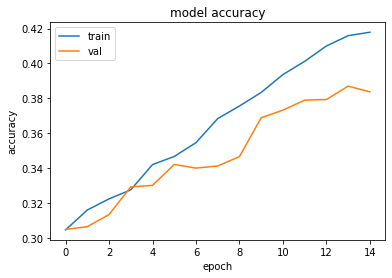

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# ### ------- Train the model ------- ###
# # Set an optimizer
# optimizer = tf.keras.optimizers.experimental.AdamW(
#     learning_rate=5e-06,
#     weight_decay = 0.01,
#     epsilon=1e-08,
#     clipnorm=1.0)
# # Set loss and metrics
# loss = {'label': CategoricalCrossentropy(from_logits = True)}
# metric = {'label': CategoricalAccuracy('accuracy')}

In [ ]:
# Ready output data for the model
y = to_categorical(preprocessed_train['label'])

x = np.array(preprocessed_train['index'])
x = x.reshape(-1, 256)

In [ ]:
!mkdir checkpoint

In [ ]:
from tensorflow import keras


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/LatentTransformer/BERT/BERT.h5')

In [ ]:
EPOCHS = 30
checkpoint_filepath = '/content/checkpoint/mymodel_{epoch}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)



In [ ]:
hist = model.fit(
    x,
    y,
    validation_split=0.2,
    batch_size=32,
    epochs=EPOCHS, 
    verbose=1,
    callbacks=[model_checkpoint_callback])

Epoch 1/30
718/718 [==============================] - 160s 223ms/step - loss: 1.4798 - accuracy: 0.4331 - val_loss: 1.5791 - val_accuracy: 0.3988
Epoch 2/30
718/718 [==============================] - 159s 222ms/step - loss: 1.4636 - accuracy: 0.4382 - val_loss: 1.5998 - val_accuracy: 0.3929
Epoch 3/30
718/718 [==============================] - 159s 222ms/step - loss: 1.4503 - accuracy: 0.4449 - val_loss: 1.6435 - val_accuracy: 0.3978
Epoch 4/30
718/718 [==============================] - 160s 223ms/step - loss: 1.4378 - accuracy: 0.4509 - val_loss: 1.5653 - val_accuracy: 0.4070
Epoch 5/30
718/718 [==============================] - 159s 222ms/step - loss: 1.4254 - accuracy: 0.4538 - val_loss: 1.5746 - val_accuracy: 0.4011
Epoch 6/30
718/718 [==============================] - 159s 222ms/step - loss: 1.4140 - accuracy: 0.4621 - val_loss: 1.6293 - val_accuracy: 0.3960
Epoch 7/30
718/718 [==============================] - 159s 222ms/step - loss: 1.3943 - accuracy: 0.4712 - val_loss: 1.6449 -

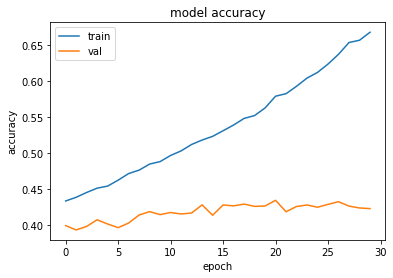

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('BERT.h5')
!cp '/content/BERT.h5' '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/BERT/'

In [ ]:
!cp '/content/checkpoint/mymodel_21.h5' '/content/drive/MyDrive/Colab Notebooks/LatentTransformer/BERT/'